###Nama      : Aprillia Nur Azizah 
###Unsername : aprillianuraz
###Email     : aprilliaazizah3@gmail.com

In [1]:
import tensorflow as tf
import zipfile, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Dicoding/Dataset/animals.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [4]:
base_dir = '/tmp/animals'

In [5]:
#print total images in cats, dogs, and panda
print('total cats :', len(os.listdir('/tmp/animals/cats')))
print('total dogs:', len(os.listdir('/tmp/animals/dogs')))
print('total panda :', len(os.listdir('/tmp/animals/panda')))

total cats : 1000
total dogs: 1000
total panda : 1000


In [6]:
#image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,       
    rescale=1./255,
    shear_range=0.15,
    fill_mode="nearest",
    horizontal_flip=True,
    validation_split=0.2) #20% validation data

In [7]:
batch_size=32

In [8]:
#data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 
validation_generator = train_datagen.flow_from_directory(
    base_dir, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [9]:
steps_per_epoch = len(train_generator)/batch_size*10
validation_steps = len(validation_generator)/batch_size*10

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>= 0.86 and logs.get('accuracy')> 0.86):#stop the training if val_accuary >= 0.86
      print("\n Accuracy dan Validation Accuracy sudah mencapai > 86% ") 
      self.model.stop_training = True

callbacks = myCallback()

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (150, 150, 3), 
                  include_top = False, 
                  weights = 'imagenet')

In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.models.Model(base_model.input, x)
model = Sequential(layers=model.layers)
model.compile(optimizer =  tf.optimizers.Adam(), loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       2

In [14]:
history = model.fit(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        epochs = 30,
        validation_data=validation_generator,   
        callbacks=[callbacks])

Epoch 1/30
23/23 [==============================] - 25s 780ms/step - loss: 1.6957 - accuracy: 0.5326 - val_loss: 0.7061 - val_accuracy: 0.6867
Epoch 2/30
23/23 [==============================] - 14s 602ms/step - loss: 0.6544 - accuracy: 0.7292 - val_loss: 0.4470 - val_accuracy: 0.8200
Epoch 3/30
23/23 [==============================] - 14s 609ms/step - loss: 0.4371 - accuracy: 0.8242 - val_loss: 0.3898 - val_accuracy: 0.8450
Epoch 4/30
23/23 [==============================] - 14s 611ms/step - loss: 0.4009 - accuracy: 0.8333 - val_loss: 0.4010 - val_accuracy: 0.8400
Epoch 5/30
23/23 [==============================] - 14s 613ms/step - loss: 0.3770 - accuracy: 0.8464 - val_loss: 0.3696 - val_accuracy: 0.8633
Epoch 6/30
23/23 [==============================] - 14s 608ms/step - loss: 0.3309 - accuracy: 0.8802 - val_loss: 0.3489 - val_accuracy: 0.8683

 Accuracy dan Validation Accuracy sudah mencapai > 86% 


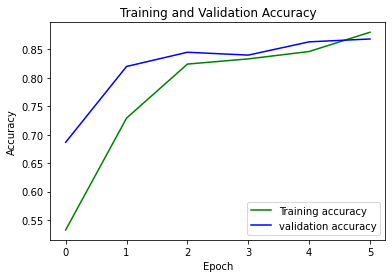

In [18]:
#Accuracy Plot
accry = history.history['accuracy']
validation_accry = history.history['val_accuracy']
plt.plot(accry, 'g', label='Training accuracy')
plt.plot(validation_accry , 'b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

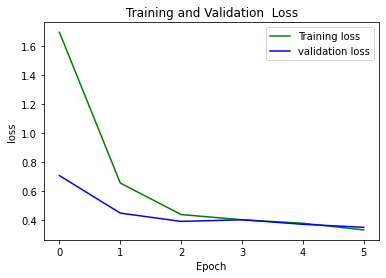

In [19]:
#Loss Plot
loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(loss, 'g', label='Training loss')
plt.plot(validation_loss , 'b', label='validation loss')
plt.title('Training and Validation  Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [17]:
#Convert TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpsx4sbq6b/assets
